# Mastering maplib --- sandbox environment
_Connected Data London 2025_

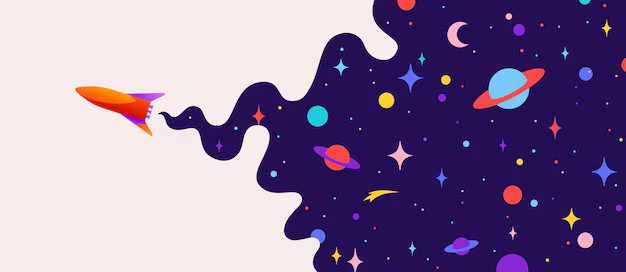

Welcome to this **maplib** sandbox based upon the masterclass! Play around and have fun. :-) 

### Agenda
- Data frames
- OTTR and mapping
- Ontology
- SHACL validation
- SPARQL 
- Datalog reasoning

### Resources
**Scroll down at the end of this notebook to find a list of resources.**

In [ ]:
import polars as pl
pl.Config.set_fmt_str_lengths(150)

## Data frames

maplib use [Polars](https://pola.rs/) data frames for handling instance data. 

Data sources used in this demo: [planets.csv](https://github.com/devstronomy/nasa-data-scraper/tree/master) [satellites.csv](https://github.com/devstronomy/nasa-data-scraper/tree/master) [stars.csv](https://www.kaggle.com/datasets/waqi786/stars-dataset/data)


In [ ]:
df_planets = pl.read_csv("../data/planets.csv")

In [ ]:
# Having a look at what data we have to play with
print(df_planets)
print(df_planets.columns)

In [ ]:
# Look at the content in column "planet". Can we use this information as our global unique identifier for planet?
print(df_planets["planet"])

In [ ]:
# Probably yes, for this case. But we need to create a planet URI to use as subject
df_planets = df_planets.with_columns( 
    ("http://data.treehouse.example/" + pl.col("planet")).alias("planet_uri")
)
print(df_planets["planet_uri"])

In [ ]:
# Let's select a few columns to work with
df_planets = df_planets.select(
    ["planet", "planet_uri", "mean_temperature", "length_of_day", "orbital_period"]
)
print(df_planets)

#### Satellites

In [ ]:
df_satellites = pl.read_csv("../data/satellites.csv")
df_satellites = df_satellites.with_columns(
    ("http://data.treehouse.example/" + pl.col("planet")).alias("planet_uri")
)
df_satellites = df_satellites.with_columns(
    ("http://data.treehouse.example/" + pl.col("name")
    .str.replace_all("/", "-"))
    .str.replace_all(" ", "-")
    .alias("satellite_uri")
)
df_satellites = df_satellites.select(
    ["name", "planet_uri", "satellite_uri", "albedo", "radius"]
)

df_satellites = (
df_satellites
    .with_columns(
    pl.col("albedo")
    .cast(pl.Float64, strict=False)     
    .alias("albedo")
    )
    .with_columns(
    pl.col("radius")
    .cast(pl.Float64, strict=False)     
    .alias("radius")
    )
)

print(df_satellites)

## Mapping

**maplib** use [Reasonable Ontology Templates](https://ottr.xyz/) (OTTR) for serialising instance data stored in data frames to RDF.

OTTR provides a syntax for creating templates, called stOTTR, and is a bit similar to RDF Turtle, but not quite. 

```
@prefix : <http://data.treehouse.example/> .
@prefix tpl: <http://data.treehouse.example/tpl/> .
@prefix ottr: <http://ns.ottr.xyz/0.4/> .
@prefix rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs:  <http://www.w3.org/2000/01/rdf-schema#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .


tpl:Planet[ 
    ! ottr:IRI ?planet_uri,
    xsd:string ?planet,
    xsd:long ?mean_temperature,
    xsd:double ?length_of_day,
    xsd:double ?orbital_period
 ] :: {
    ottr:Triple(?planet_uri, rdf:type, :Planet), 
    ottr:Triple(?planet_uri, rdfs:label, ?planet),
    ottr:Triple(?planet_uri, :meanTemperature, ?mean_temperature),
    ottr:Triple(?planet_uri, :lengthOfDay, ?length_of_day),
    ottr:Triple(?planet_uri, :orbitalPeriod, ?orbital_period)
} .
```

1. First, we define all the prefixes we need.
2. Then we create the template signature `tpl:Planet[ ... ]`
   * Moderators `!` for mandatory and `?` for optional.
   * Typesetting `ottr:IRI` and `xsd:string` etc, where data type is known.
   * Name of variable as `?planet_uri` **must** correspond to data frame column header.
3. Instructions for serialisation given in body `:: { ... } .`.
   * maplib currently supports `ottr:Triple(?s, ?p, ?o)` and reusage of custom templates within the same file, it is on the roadmap to support the rest of tpl.ottr.xyz.

If you need a kickstart to building templates, you can simply use the function `m.map_default(df, subject)` to generate a template based on your data frame. ♥

If you need more information about OTTR, have a look at the author's [OTTR Masterclass](https://github.com/veleda/ottr-masterclass).

In [ ]:
from maplib import Model

# Serialise data frame content to RDF using OTTR template
with open("../tpl/tpl.stottr", "r") as file:
    tpl = file.read()
m = Model()
m.add_template(tpl)

m.map("http://data.treehouse.example/tpl/Planet", df_planets)

In [ ]:
#print(m.map_default(df_planets, "planet_uri"))

In [ ]:
# Count number of triples serialised from planet
count = """
    SELECT (COUNT(?s) AS ?count)
    WHERE { ?s ?p ?o . }
"""
m.query(count)

In [ ]:
m.map("http://data.treehouse.example/tpl/Satellite", df_satellites)
m.query(count)

## Ontology
This masterclass uses a simple ontology made in Protégé, including simple property semantics (domain & range) and class membership.

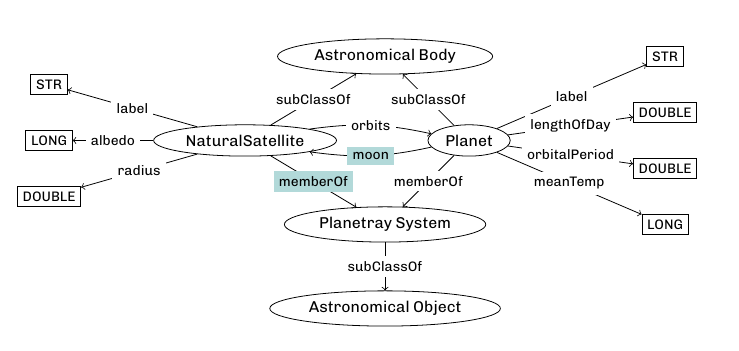

In [ ]:
# Merge the ontology in with the RDF Model
m.read("../ttl/ast.ttl")
m.query(count)

## SHACL validation
We are including some simple shapes for validating a tiny bit of our data graph.

```ttl
rule:AstronomicalBody a sh:NodeShape ;
    sh:targetClass :AstronomicalBody ;
    sh:property rule:AstronomicalBody-memberOf .

rule:AstronomicalBody-memberOf a sh:PropertyShape ;
    sh:path :memberOf ;
    sh:minCount 1 ;
    sh:or (
        [ sh:class :PlanetarySystem ]
        [ sh:class :StarCluster ]
    ) .

rule:Planet a sh:NodeShape ;
    sh:targetClass :Planet ;
    sh:node rule:AstronomicalBody .

rule:NaturalSatellite a sh:NodeShape ;
    sh:targetClass :NaturalSatellite ;
    sh:node rule:AstronomicalBody .
```

These shapes says that both `:Planet` and `:NaturalSatellite` are constrained through `sh:node rule:AstronomicalBody`. `rule:AstronomicalBody` have one corresponding property shape constraining `:memeberOf` for the astronomical bodies `:Planet` and `:NaturalSatellite`. The constraint states that a astronomical body shall be `:memberOf` at least one `:PlanetarySystem` OR `:StarCluster`.

In [ ]:
# Running the validation
def validate_kg():
    m.read("../ttl/sh.ttl", graph="http://data.treehouse.example/sh/")
    report = m.validate(shape_graph="http://data.treehouse.example/sh/", include_shape_graph=False)
    
    report.graph().query(count)
    with open("../queries/focus_node_violations.rq", "r") as file:
        focus_node_violations = file.read()
    
    print(report.graph().query(focus_node_violations)["focusNode"])

validate_kg()

## SPARQL
Let's try to fix some of the issues with SPARQL! Since the constrain was that all astronomical bodies must be a `:memberOf` either a `:PlanetarySystem` or a `:StarCluster`, we can insert the fact that our planets ("Mercury", "Venus", "Earth", "Mars", "Jupiter", "Saturn", "Uranus", and "Neptune") are indeed a member of the **Solar System**.

In [ ]:
insert_query = """PREFIX : <http://data.treehouse.example/> 
PREFIX owl: <http://www.w3.org/2002/07/owl#> 
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 

# Insert the planets of the Solar System as members of the Solar System.

CONSTRUCT {
    :SolarSystem rdf:type :PlanetarySystem .
    ?s :memberOf :SolarSystem .
} 
WHERE {
  ?s rdf:type :Planet ;
    rdfs:label ?label .

    FILTER(STR(?label) IN 
      ("Mercury", "Venus", "Earth", "Mars", "Jupiter", "Saturn", "Uranus", "Neptune")
    ) 
}""" 

m.insert(insert_query)

with open("../queries/insert_individual.rq", "r") as file:
    insert_individual = file.read()

m.update(insert_individual)
m.query(count)
validate_kg()

It's a bit better, but we still miss a `:memberOf` property for all `:NaturalSatellites`.

## Datalog inference
We will not bother listing e v e r y single satellite in a list in SPARQL! Therefore, we will _infer_ the fact that satellites that orbits planets are indeed member of that thing a planet is member of also. 

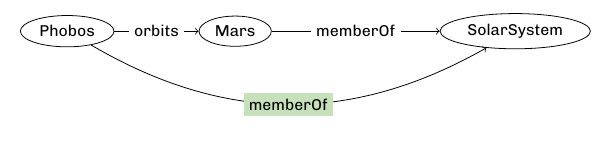


In [ ]:
datalog_rule = """PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
PREFIX : <http://data.treehouse.example/>

# If something orbits a thing that is memberOf ?z, then that something is also a member of ?z
[?x, :memberOf, ?z] :- [?x, :orbits, ?y], [?y, :memberOf, ?z] ."""

m.infer(datalog_rule)
m.query(count)
validate_kg()

There are still a few things in the report. Pluto is missing from the list of planets! Update the SPARQL-query or add a concept of Dwarf Planets. :-) 

# Resources

- [Documentation of core features in maplib](https://datatreehouse.github.io/documentation/#/page/maplib%20docs)
- [Full API documentation](https://datatreehouse.github.io/maplib/maplib.html)
- [maplib masterclass](https://github.com/DataTreehouse/maplib-masterclass)
- [OTTR spec](https://ottr.xyz/)
- [OTTR masterclass](https://github.com/veleda/ottr-masterclass)